# Question 2b5
Compare the test accuracies and the running times of the networks implemented in parts (1) – (4).

Experiment with adding dropout to the layers of networks in parts (1) – (4), and report the test accuracies. Compare and comment on the accuracies of the networks with/without dropout.

# Imports and Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2b" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2b


In [ ]:
import os
import time
import json
import csv
import re

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf

In [ ]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper functions

### read_data_chars()
Used to load in the data. Returns x_train, y_train, x_test, y_test

In [ ]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

### vocabulary(strings)
Read data with [character]. Get the unique characters in this strings and the vocab size (of characters)

In [ ]:
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

### preprocess(strings, char_to_ix, MAX_LENGTH)
Clean up a string 

In [ ]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

### make_directories()
Used to create directories that might not have been made

In [ ]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
    os.mkdir('./histories')
  if not os.path.exists('./figures'):
    os.mkdir('./figures')

### history_saver(history, filename, already_json=False)
Used to save a history object

In [ ]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [ ]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [ ]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['test_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [ ]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['test_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

# 2b5 - Comparison between first eight models
1. Word vs Character
2. CNN vs RNN
3. No dropout vs dropout

In [ ]:
def compare_test_acc(histories_json, filename, start_from_epoch=None, title=None):
  fig = plt.figure(figsize=(20,10))

  for model_name in histories_json.keys():  
    if start_from_epoch == None:
      test_acc = histories_json[model_name][model_name]['test_accuracy']
    else:
      test_acc = histories_json[model_name][model_name]['test_accuracy'][start_from_epoch:]
    plt.plot(test_acc, label=model_name + ", time taken: " + str(histories_json[model_name][model_name]['time_taken']))    
  
  if title == None:
    title = 'test accuracy against epochs'
    plt.title(title)
  else:
    plt.title(title)
  plt.ylabel('test accuracy')
  plt.xlabel('epochs')
  plt.legend(loc='lower right')
  
  plt.savefig(f'./figures/{filename}.png')

  plt.show()

In [ ]:
fnames_histories = next(os.walk('./histories'))[2]

histories_json = {}

for fname in fnames_histories:
  if fname[:2] in ['q1', 'q2', 'q3', 'q4', 'q5']:
    histories_json[fname] = history_loader(fname)

History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded


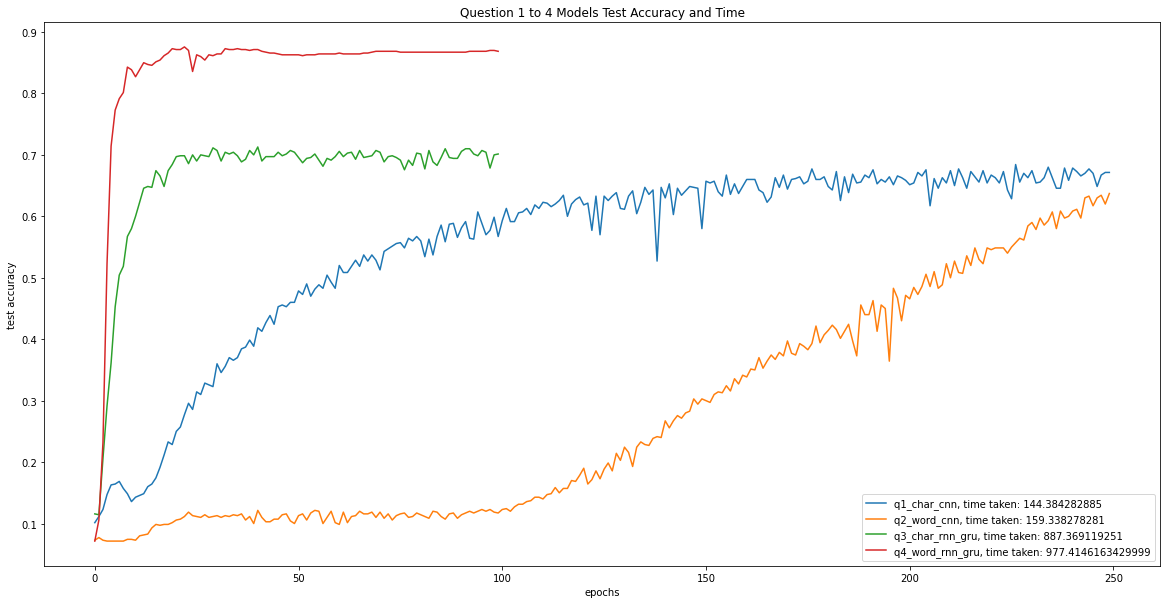

In [ ]:
models_q1_to_q4 = {}
models_q1_to_q4_filename = 'q5_compare_models_q1_to_q4'
models_q1_to_q4_title = 'Question 1 to 4 Models Test Accuracy and Time'

for model_name in ['q1_char_cnn', 'q2_word_cnn', 'q3_char_rnn_gru', 'q4_word_rnn_gru']:
  models_q1_to_q4[model_name] = histories_json[model_name]

compare_test_acc(models_q1_to_q4, models_q1_to_q4_filename, start_from_epoch=None, title=models_q1_to_q4_title)

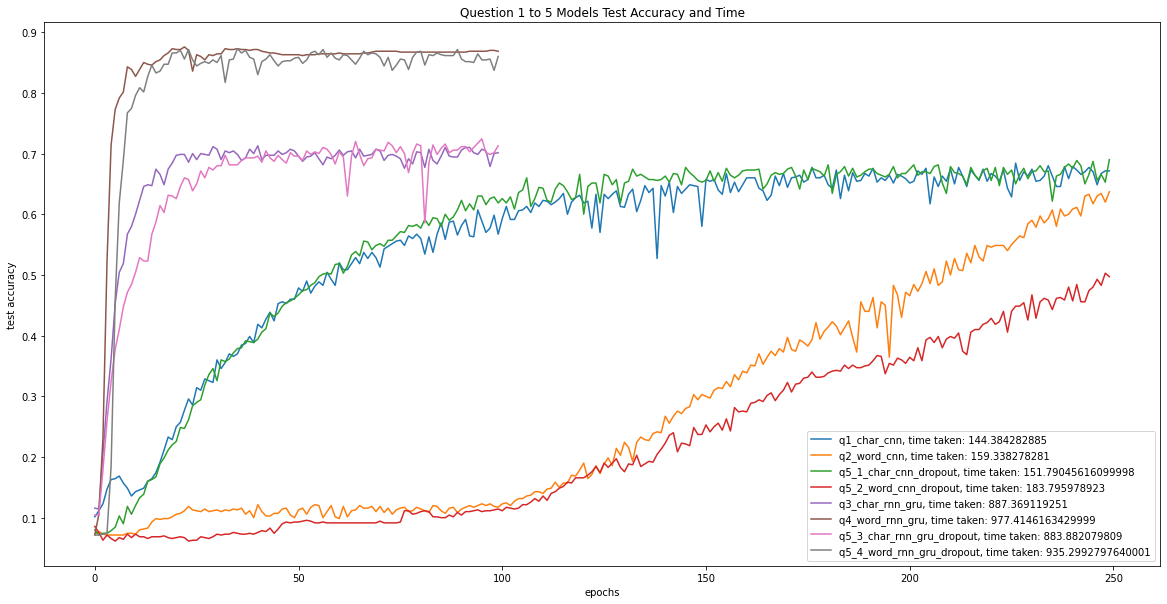

In [ ]:
models_dropout_filename = 'q5_compare_models_dropout'
models_dropout_title = 'Question 1 to 5 Models Test Accuracy and Time'

compare_test_acc(histories_json, models_dropout_filename, start_from_epoch=None, title=models_dropout_title)